# landcover-hack ODC workshop 2019

This is a test notebook to derive a level 3 classification for select areas in Australia based on the FAO LCCS landcover classification

In [1]:
import numpy
import xarray
import scipy
from matplotlib import pyplot
from matplotlib import cm
import matplotlib.gridspec as gridspec
import datacube
from datacube.storage import masking

#import classification script
import lccs_l3

Data input from AWS DEA

In [2]:
# set up object and bounds

dc = datacube.Datacube(app="le_lccs")

res = (-25, 25)

#current area is Ayr
min_x = 1500000.000
max_x = 1600000.000
min_y = -2200000.000
max_y = -2100000.000

out_crs = "EPSG:3577"

#Townsville
max_lon = 147
min_lon = 146.5
min_lat = -19.5
max_lat = -19

time = ("2010-01-01", "2010-12-15")

query=({'x':(min_x, max_x),
        'y':(min_y, max_y),
        'crs':out_crs,
        'resolution':res})


## 5 layers required for level 3 classification

- vegetat_veg_cat (layer for vegetation/non vegetation)
- aquatic_wat_cat (layer for aquatic/terrestrial
- cultman_agr_cat (layer for cultivated/natural)
- artific_urb_cat (layer for artificial surfaces/bare areas)
- artwatr_wat_cat (layer for artificial water/natural water)

### vegetat_veg_cat

In [3]:
var_xarray = dc.load(product="fc_percentile_albers_annual",# measurements=["PV_PC_50", "NPV_PC_50"], 
                     time=time, **query)
var_xarray = masking.mask_invalid_data(var_xarray)

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:    (time: 1, x: 4000, y: 4000)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01
  * y          (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x          (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    BS_PC_10   (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV_PC_10   (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV_PC_10  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    BS_PC_50   (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV_PC_50   (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV_PC_50  (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    BS_PC_90   (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    PV_PC_90   (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    NPV_PC_90  (time, y, x) float64 nan nan nan nan nan nan nan nan 

In [4]:
# Create binary layer representing vegetated (1) and non-vegetated (0)
vegetat_veg_cat_ds = ((var_xarray["PV_PC_50"] >= 50) | (var_xarray["NPV_PC_50"] >= 50))

In [5]:
# Convert to Dataset and add name
vegetat_veg_cat_ds = vegetat_veg_cat_ds.to_dataset(name="vegetat_veg_cat")

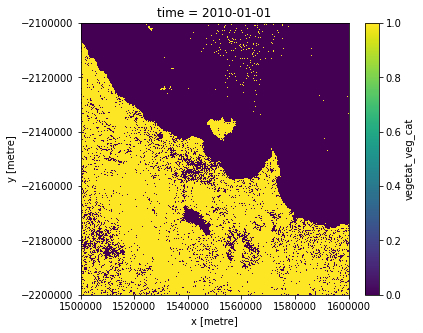

In [6]:
# Plot output
vegetat_veg_cat_ds["vegetat_veg_cat"].plot(figsize=(6, 5))

In [7]:
vegetat_veg_cat_ds = vegetat_veg_cat_ds.squeeze().drop('time')

### aquatic_wat_cat

In [8]:
var_xarray = dc.load(product="wofs_annual_summary",measurements=["frequency"], time=time, **query)

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:    (time: 1, x: 4000, y: 4000)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01
  * y          (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x          (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    frequency  (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Attributes:
    crs:      EPSG:3577

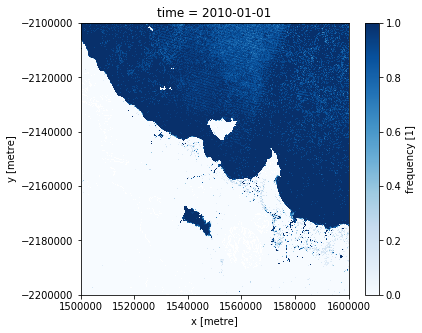

In [9]:
# Plot data
var_xarray = masking.mask_invalid_data(var_xarray)
var_xarray.frequency.plot(figsize=(6, 5), cmap = 'Blues')

In [10]:
# Create binary layer representing aquatic (1) and terrestrial (0)
aquatic_wat_cat_ds = ((var_xarray["frequency"] >= 0.01))

In [11]:
# Convert to Dataset and add name
aquatic_wat_cat_ds = aquatic_wat_cat_ds.to_dataset(name="aquatic_wat_cat")

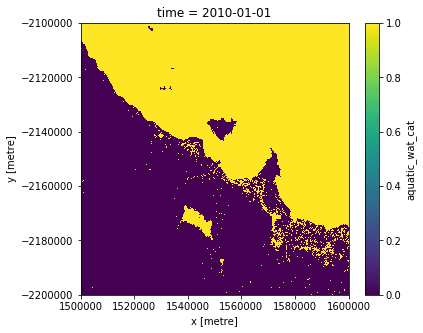

In [12]:
# Plot output
aquatic_wat_cat_ds["aquatic_wat_cat"].plot(figsize=(6, 5))

In [13]:
aquatic_wat_cat_ds = aquatic_wat_cat_ds.squeeze().drop('time')

### cultman_agr_cat

In [14]:
ls8_mads = dc.load(product="ls5_nbart_tmad_annual", time=time, **query)

In [15]:
cultman_agr_cat = ((ls8_mads["edev"] > 0.115))

In [16]:
cultman_agr_cat = cultman_agr_cat.to_dataset(name="cultman_agr_cat")

In [17]:
cultman_agr_cat = cultman_agr_cat.squeeze().drop('time')

### artific_urb_cat

#### Dry Bare Soil Index - DBSI

In [18]:
# Load data
ls8_gm = dc.load(product="ls5_nbart_geomedian_annual", time=time, **query)
ls8_gm = masking.mask_invalid_data(ls8_gm)

In [19]:
# calculate ndvi
ndvi = ((ls8_gm.nir - ls8_gm.red) / (ls8_gm.nir + ls8_gm.red)).squeeze().drop('time')

# # calculate DBSI
# dbsi = (((ls8_gm.swir1 - ls8_gm.green) / (ls8_gm.swir1 + ls8_gm.green)) - ndvi).squeeze().drop('time')
# DBSI_bare = (dbsi > .26)
# DBSI_bare.plot()

In [20]:
# dbsi.plot()

In [21]:
# # Create binary layer representing urban (1) and baresoil (0)
# artific_urb_cat = (~DBSI_bare).to_dataset(name="artific_urb_cat")

# Alternative artifical surface index

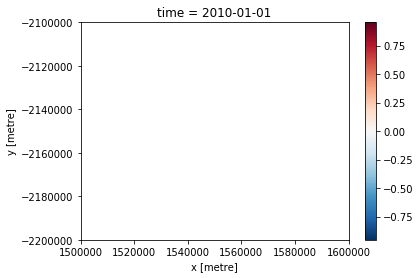

In [22]:
NDBI = ((ls8_gm.nir - ls8_gm.swir1) /  (ls8_gm.nir + ls8_gm.swir1))
NDBI.plot()

In [23]:
# #urbanindex = 7-4/7+4

# UI = (ls8_gm.swir2-ls8_gm.nir) / (ls8_gm.swir2+ls8_gm.nir)
# UI = UI > 0

# UI.plot()

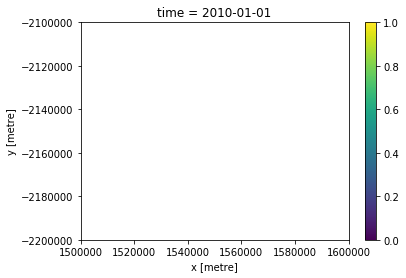

In [24]:
x = NDBI.where(ndvi<0.25)
y = x < 0
y.plot()

In [25]:
# Create binary layer representing urban (1) and baresoil (0)
artific_urb_cat = (y.squeeze().drop('time')).to_dataset(name="artific_urb_cat")

#### MADs

In [26]:
# # Load data
# ls8_mad = dc.load(product="ls8_nbart_tmad_annual", **query)
# ls8_mad = masking.mask_invalid_data(ls8_mad)


In [27]:
# bc = ls8_mad.bcdev.isel(time=0)
# euc = ls8_mad.edev.isel(time=0)
# spec = ls8_mad.sdev.isel(time=0)

# # Plot MAD data
# # %matplotlib inline
# # fig=pyplot.figure(figsize=(10, 10))
# # columns = 2
# # rows = 1
# # ax = fig.add_subplot(1, 2, 1)
# # ax.set_title("MAD spectral changes")
# # ax.imshow(spec)

# # ax1 = fig.add_subplot(1, 2, 2)
# # ax1.set_title("MAD - very little spectral change")
# # ax1.imshow(spec.where(spec < .002))
# # pyplot.show()

In [28]:
# Create binary layer representing urban (1) and baresoil (0)
#artific_urb_cat = (spec < .002).to_dataset(name="artific_urb_cat")

### artwatr_wat_cat

In [29]:
var_xarray = dc.load(product="geofabric",measurements=["band1"], **query)

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2014-02-10T18:32:38
  * y        (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 -2.1e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Data variables:
    band1    (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

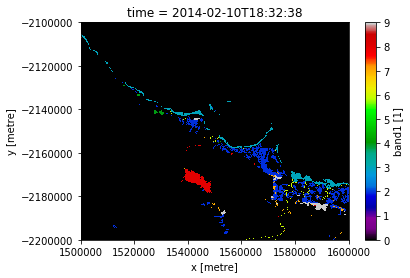

In [30]:
# Plot data
var_xarray.band1.isel(time=0).plot.imshow(cmap="nipy_spectral")

In [31]:
# Create binary layer representing artificial water (1) and natural water (0)
artwatr_wat_cat_ds = ((var_xarray["band1"] == 1) | (var_xarray["band1"] == 8))

In [32]:
# Convert to Dataset and add name
artwatr_wat_cat_ds = artwatr_wat_cat_ds.to_dataset(name="artwatr_wat_cat")

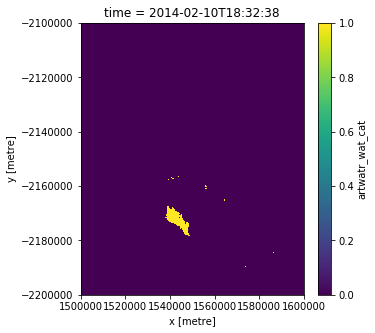

In [33]:
# Plot output
artwatr_wat_cat_ds["artwatr_wat_cat"].plot(figsize=(5, 5))

In [34]:
artwatr_wat_cat_ds = artwatr_wat_cat_ds.squeeze().drop('time')

In [35]:
variables_xarray_list = []
variables_xarray_list.append(artwatr_wat_cat_ds)
variables_xarray_list.append(aquatic_wat_cat_ds)
variables_xarray_list.append(vegetat_veg_cat_ds)
variables_xarray_list.append(cultman_agr_cat)
variables_xarray_list.append(artific_urb_cat)

## Classification

The LCCS classificaition is hierachial. The 8 classes are shown below.

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |


In [36]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)

In [37]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [38]:
# Save classification values back to xarray
out_class_xarray = xarray.Dataset({"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
                                   "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
                                   "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])
classification_data

col_level2 = cm.get_cmap("Set1", 2)
# classification_data.level2.plot(cmap=(col_level2))

In [39]:
print("level 1:",numpy.unique(classification_data.level1))
print("level 2:",numpy.unique(classification_data.level2))
print("level 3:",numpy.unique(classification_data.level3))

level 1: [100 200]
level 2: [10 20]
level 3: [111 112 123 124 215 216 227 228]


In [40]:
# from cartopy.feature import NaturalEarthFeature
# shp_fn = shpreader.natural_earth(resolution=resolution, category='cultural', name='populated_places')

# states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
#                                  name='admin_1_states_provinces_shp')

<IPython.core.display.Javascript object>


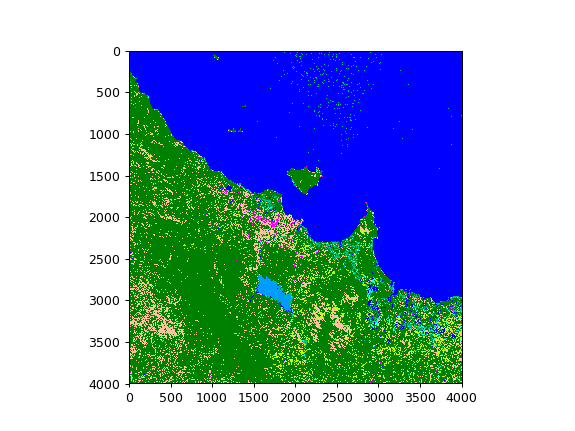

In [41]:
%matplotlib notebook
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))
#classification_data.level3.plot(cmap='', figsize=(10,10))

In [42]:
import gdal
def array_to_geotiff(fname, data, geo_transform, projection,
                     nodata_val=0, dtype=gdal.GDT_Float32):
    """
    Create a single band GeoTIFF file with data from an array. 
    
    Because this works with simple arrays rather than xarray datasets from DEA, it requires
    geotransform info ("(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size)") and 
    projection data (in "WKT" format) for the output raster. These are typically obtained from 
    an existing raster using the following GDAL calls:
    
        import gdal
        gdal_dataset = gdal.Open(raster_path)
        geotrans = gdal_dataset.GetGeoTransform()
        prj = gdal_dataset.GetProjection()
    
    ...or alternatively, directly from an xarray dataset:
    
        geotrans = xarraydataset.geobox.transform.to_gdal()
        prj = xarraydataset.geobox.crs.wkt
    
    Last modified: March 2018
    Author: Robbi Bishop-Taylor
    
    :param fname: 
        Output geotiff file path including extension
        
    :param data: 
        Input array to export as a geotiff
        
    :param geo_transform: 
        Geotransform for output raster; e.g. "(upleft_x, x_size, x_rotation, 
        upleft_y, y_rotation, y_size)"
        
    :param projection:
        Projection for output raster (in "WKT" format)
        
    :param nodata_val: 
        Value to convert to nodata in the output raster; default 0
        
    :param dtype: 
        Optionally set the dtype of the output raster; can be useful when exporting 
        an array of float or integer values. Defaults to gdal.GDT_Float32
        
    """

    # Set up driver
    driver = gdal.GetDriverByName('GTiff')

    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, dtype)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)

    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)

    # Close file
    dataset = None

In [43]:
#create 'transform' tuple that will define the dimensions of the rasterized shapefile and exporty
import osr
srs = osr.SpatialReference()
srs.ImportFromEPSG(3577)
prj_wkt = srs.ExportToWkt()

easting = float(ls8_gm.x[0])
W_E_pixelRes = float(ls8_gm.y[0] - ls8_gm.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(ls8_gm.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(ls8_gm.x[0] - ls8_gm.x[1])

transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

array_to_geotiff('bleh_0.tif',
                              level3,
                              geo_transform = transform, 
                              projection = prj_wkt, 
                              nodata_val=0)